**7. Analyse offensive value per pass for left and right footed LCBs for four defender and three/five defender formation**

We have considered the offensive value for our analysis, and not VAEP in entirety, because of the following reasons:
1. As our problem statement is to understand how differently footed LCBs contribute to the attacking buildup, we believe offensive value suffices to take threat into account.
2. In Tom Decroos's analysis ['Valuing On-the-Ball Actions in Soccer: A Critical Comparison of xT and VAEP'](https://tomdecroos.github.io/reports/xt_vs_vaep.pdf), offensive value is found to be robust, which makes offensive value a suitable metric for further analysis.

The following tasks have been taken into account in this notebook:
1. Segregate accurate progressive passes from the accurate pass pool and calculate the threat per pass in different region for both left and right footed LCB. This process is performed for four defender formation and three/five defender formation seperately
2. Plot the threat results for four defender and three/five defender formations

# Imports 

In [1]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('max_columns',1000)

# Data 

In [3]:
# Loading clusters with VAEP values as a list of dataframes
cluster_names = ['four_defs','three_five_defs']
df_clusters = list()
for name in cluster_names:
    df_clusters.append(pd.read_pickle(f'../data_top5/clusters/clusters_vaep/cluster_{name}.pkl'))

In [4]:
# Reseting the indexes of dfs in df_clusters
for df in df_clusters:
    df.reset_index(inplace = True)

# Functions 

In [5]:
# Function to get start and end location points for every row in df
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(np.round(point[1],2))
                start_points.append(np.round(point[0],2))
    return start_points,end_points

In [6]:
# Function to get start and end location points for a whole df column
def getstartendfull(locs,off):
    end_points = list()
    start_points = list()
    off_values = list()
    for match,match_off in zip(locs,off):
        for point,off in zip(match,match_off):
            if point != []:
                end_points.append(np.round(point[1],2))
                start_points.append(np.round(point[0],2))
                off_values.append(off)
    return start_points,end_points,off_values

In [7]:
# Function to apply progressive pass filter and get VAEP values for these passes
def distfilter(locs,off):
    loc_start, loc_end = getstartend(locs)
    prog_accpasslocs = list()
    prog_accpassoff = list()
    for p1,p2,off in zip(loc_start,loc_end,off):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and p2[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_accpasslocs.append([np.round(p1,2),np.round(p2,2)])
            prog_accpassoff.append(off)
        elif p1[0] > 52 and p2[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_accpasslocs.append([np.round(p1,2),np.round(p2,2)])
            prog_accpassoff.append(off)
        elif p1[0] < 52 and p2[0] > 52 and dist >= 15 and p1[0] < p2[0]:
            prog_accpasslocs.append([np.round(p1,2),np.round(p2,2)])
            prog_accpassoff.append(off)
    return pd.Series([prog_accpasslocs,prog_accpassoff])


# Getting Progressive Passes 

In [11]:
# Creating progressive pass and progressive pass vaep columns for LCB
df_clusters_prog_off = list()
for df in df_clusters:
    if df['backline'][0] == 4:
        df[['L_CB_progaccpassloc', 'L_CB_progaccpassoff']] = df.apply(
            lambda x: distfilter(x['L_CB_accpassloc'], x['L_CB_accoff']),
            axis=1)
    elif df['backline'][0] in [3, 5]:
        df[['LCB_progaccpassloc', 'LCB_progaccpassoff']] = df.apply(
            lambda x: distfilter(x['LCB_accpassloc'], x['LCB_accoff']), axis=1)
    df_clusters_prog_off.append(df)

In [12]:
# Counting number of progressive passes
prog_counter = 0
prog_off_counter = 0
for df in df_clusters_prog_off:
    if df['backline'][0] in [3,5]:
        start,end,off = getstartendfull(df['LCB_progaccpassloc'],df['LCB_progaccpassoff'])
        prog_counter = prog_counter + len(start)
        prog_off_counter = prog_off_counter + len(off)
    elif df['backline'][0] == 4:
        start,end,off = getstartendfull(df['L_CB_progaccpassloc'],df['L_CB_progaccpassoff'])
        prog_counter = prog_counter + len(start)
        prog_off_counter = prog_off_counter + len(off)

In [13]:
# Counting number of accurate passes
acc_counter = 0
acc_off_counter = 0
for df in df_clusters_prog_off:
    if df['backline'][0] in [3,5]:
        start,end,off = getstartendfull(df['LCB_accpassloc'],df['LCB_accoff'])
        acc_counter = acc_counter + len(start)
        acc_off_counter = acc_off_counter + len(off)
    elif df['backline'][0] == 4:
        start,end,off = getstartendfull(df['L_CB_accpassloc'],df['L_CB_accoff'])
        acc_counter = acc_counter + len(start)
        acc_off_counter = acc_off_counter + len(off)

In [14]:
acc_counter, prog_counter

(147130, 46454)

In [15]:
acc_off_counter,prog_off_counter

(147130, 46454)

In [16]:
# Saving the updated clusters as pickle files
cluster_names = ['four_defs','three_five_defs']
for i, df in enumerate(df_clusters_prog_off):
    df.to_pickle(f'../data_top5/clusters/clusters_prog_off/cluster_prog_off_{cluster_names[i]}.pkl')

In [15]:
# rrrl_new = pd.read_pickle('./FootballPlayerFootedness/data/clusters/clusters_prog_vaep/cluster_prog_vaep_rrrl.pkl')

# Value Added by Progressive Passes 

## Functions 

In [18]:
## Function to generate x and y coordinates from a list of locations
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [19]:
# Function to draw a football pitch
def draw_pitch(line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
        circle4 = plt.Circle((93, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle5 = plt.Circle((11, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle6 = plt.Circle((52, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-', color="None", zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-', color='None', zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color="None", zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
        
    return fig, ax

In [20]:
# Function to segregate the progressive passes into different regions
def get_prog_pass_region(x, y):
    x_rightflank_attack, x_rightflank_def, x_leftflank_attack, x_leftflank_def, x_rightcentral_attack, x_rightcentral_def, x_leftcentral_attack, x_leftcentral_def = list(
    ), list(), list(), list(), list(), list(), list(), list()
    if x != []:
        x_rightflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
        ]
        y_rightflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
        ]
        x_rightflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
        ]
        y_rightflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
        ]
        x_leftflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
        ]
        y_leftflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
        ]
        x_leftflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
        ]
        y_leftflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
        ]
        x_rightcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
        ]
        y_rightcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
        ]
        x_rightcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
        ]
        y_rightcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
        ]
        x_leftcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
        ]
        y_leftcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
        ]
        x_leftcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
        ]
        y_leftcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
        ]
    return [
        len(x_leftflank_def),
        len(x_leftcentral_def),
        len(x_rightcentral_def),
        len(x_rightflank_def),
        len(x_leftflank_attack),
        len(x_leftcentral_attack),
        len(x_rightcentral_attack),
        len(x_rightflank_attack)
    ]

In [21]:
# Creating a pcolormesh plot for progressive accurate passes and VAEPs in different regions
def regionwiseoff(df):
    if df['backline'][0] == 4:
        progaccpassloc = df['L_CB_progaccpassloc'].tolist()
        progaccpassoff = df['L_CB_progaccpassoff'].tolist()
    elif df['backline'][0] in [3, 5]:
        progaccpassloc = df['LCB_progaccpassloc'].tolist()
        progaccpassoff = df['LCB_progaccpassoff'].tolist()

    df_prog_acc_start, df_prog_acc_end, df_prog_acc_vaep = getstartendfull(
        progaccpassloc, progaccpassoff)
    df_prog_acc_end_x, df_prog_acc_end_y = getxy(df_prog_acc_end)
    progpass_region_acc = get_prog_pass_region(df_prog_acc_end_x,
                                               df_prog_acc_end_y)
    progpass_def_region_acc = progpass_region_acc[:4]
    progpass_att_region_acc = progpass_region_acc[4:8]
    off_region_defence, off_region_attack = get_region(df_prog_acc_end_x,
                                                       df_prog_acc_end_y,
                                                       df_prog_acc_vaep)
    off_region_defence_perpass_scaled = [
        i / j * 1000
        for i, j in zip(off_region_defence, progpass_def_region_acc)
    ]
    off_region_attack_perpass_scaled = [
        i / j * 1000
        for i, j in zip(off_region_attack, progpass_att_region_acc)
    ]
    x_marks = ['0-52', '52-104']
    y_marks = ['51-68', '34-51', '17-34', '0-17']
    df_region = pd.DataFrame(zip(off_region_defence_perpass_scaled,
                                 off_region_attack_perpass_scaled),
                             columns=x_marks,
                             index=y_marks)
    return df_region

In [22]:
# Calcuating total value added by passes in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_region(x,y,off):
    off_rightflank_attack,off_rightflank_defence,off_rightcentral_attack,off_rightcentral_defence,off_leftcentral_attack,off_leftcentral_defence,off_leftflank_attack,off_leftflank_defence = list(),list(),list(),list(),list(),list(),list(),list()
    off_rightflank_attack = np.sum([off[i] for i in range(len(x)) if (x[i]>=52) and (y[i]<=17)])
    off_rightflank_defence = np.sum([off[i] for i in range(len(x)) if (x[i]<52) and (y[i]<=17)])
    off_rightcentral_attack = np.sum([off[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>17) and (y[i]<=34)])
    off_rightcentral_defence = np.sum([off[i] for i in range(len(x)) if (x[i]<52) and (y[i]>17) and (y[i]<=34)])
    off_leftcentral_attack = np.sum([off[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>34) and (y[i]<=51)])
    off_leftcentral_defence = np.sum([off[i] for i in range(len(x)) if (x[i]<52) and (y[i]>34) and (y[i]<=51)])
    off_leftflank_attack = np.sum([off[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>51) and (y[i]<=68)])
    off_leftflank_defence = np.sum([off[i] for i in range(len(x)) if (x[i]<52) and (y[i]>51) and (y[i]<=68)])
    
    return [off_leftflank_defence,off_leftcentral_defence,off_rightcentral_defence,off_rightflank_defence],[off_leftflank_attack,off_leftcentral_attack,off_rightcentral_attack,off_rightflank_attack]

In [36]:
# Function to plot a pcolor mesh, describing pass value contribution in each region
def pcolorplotter(df,title,name):
    fig = px.imshow(df.values,x=df.columns.values.tolist(),y=df.index.values.tolist(),title=title)
    fig.show()
    fig.write_html(f"../data_top5/threat_plots/{name}.html")

## Threat patterns for four defender formation for LCB

In [24]:
four_defs = pd.read_pickle('../data_top5/clusters/clusters_prog_off/cluster_prog_off_four_defs.pkl')

In [25]:
three_five_defs = pd.read_pickle(
    '../data_top5/clusters/clusters_prog_off/cluster_prog_off_three_five_defs.pkl'
)

In [28]:
four_defs_lf_lcbs = four_defs[four_defs['footedness'].apply(lambda x: x.split('-')[-2]=='left')]
four_defs_rf_lcbs = four_defs[four_defs['footedness'].apply(lambda x: x.split('-')[-2]=='right')]

In [29]:
def three_five_lcb_foot(row,foot):
    if row['backline']==3:
        return row['footedness'].split('-')[-1]==foot
    else:
        return row['footedness'].split('-')[-2]==foot

In [30]:
three_five_defs_lf_lcbs = three_five_defs[three_five_defs[[
    'backline', 'footedness'
]].apply(lambda x: three_five_lcb_foot(x, 'left'), axis=1)]
three_five_defs_rf_lcbs = three_five_defs[three_five_defs[[
    'backline', 'footedness'
]].apply(lambda x: three_five_lcb_foot(x, 'right'), axis=1)]

In [31]:
four_defs_lf_lcbs.reset_index(inplace=True,drop=True)
four_defs_rf_lcbs.reset_index(inplace=True,drop=True)
three_five_defs_lf_lcbs.reset_index(inplace=True,drop=True)
three_five_defs_rf_lcbs.reset_index(inplace=True,drop=True)

In [32]:
four_defs_rf_lcbs_regionwiseoff = regionwiseoff(four_defs_rf_lcbs)
four_defs_lf_lcbs_regionwiseoff = regionwiseoff(four_defs_lf_lcbs)

**VAEP for each region for Right Footed LCB**

In [33]:
four_defs_rf_lcbs_regionwiseoff

,0-52,52-104
51-68,2.878185,3.606990
34-51,4.039103,9.625669
17-34,1.685311,9.123298
0-17,1.839825,4.978994


**VAEP for each region for Left Footed LCB**

In [34]:
four_defs_lf_lcbs_regionwiseoff

,0-52,52-104
51-68,2.890350,3.880101
34-51,4.673079,9.824284
17-34,1.629990,10.884574
0-17,1.825879,5.846809


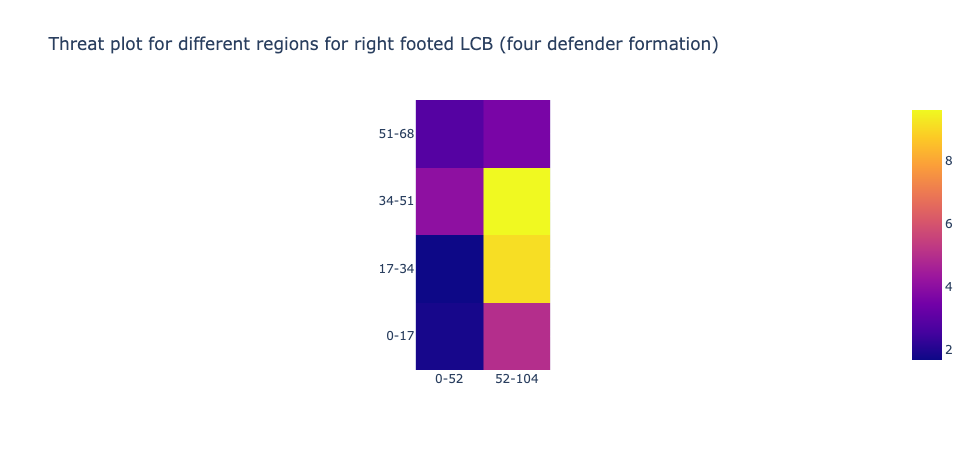

In [37]:
# The graphs have been saved in 'threat_plots' data folder
pcolorplotter(
    four_defs_rf_lcbs_regionwiseoff,
    'Threat plot for different regions for right footed LCB (four defender formation)',
    'offvalue_right_lcb_4def')

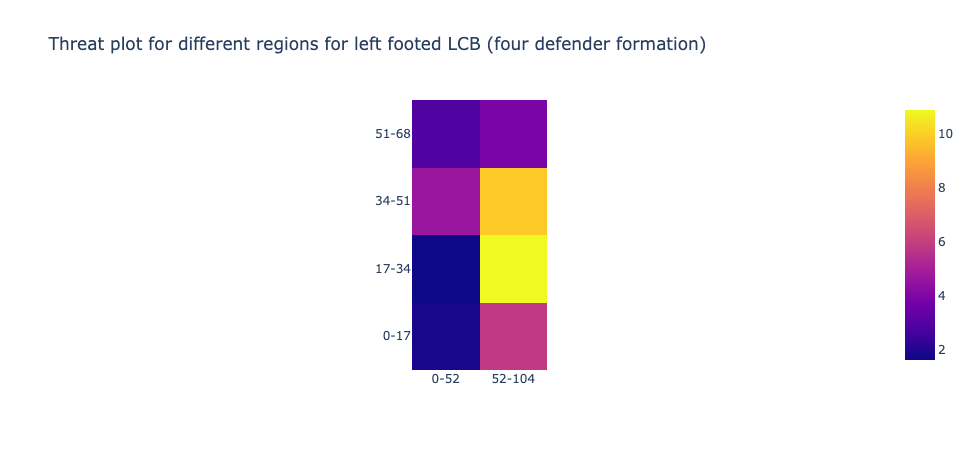

In [38]:
# The graphs have been saved in 'threat_plots' data folder
pcolorplotter(
    four_defs_lf_lcbs_regionwiseoff,
    'Threat plot for different regions for left footed LCB (four defender formation)',
    'offvalue_left_lcb_4def')

## Threat patterns for three/five defender formation for LCB

In [39]:
# three_five_clusters = ['rrl','rrr','rll','rrrll','rrrrl','rlr','rrrlr','rrlll']
# lcb_lf_clusters = ['rrl','rll','rrrll','rrrlr','rrlll']
# lcb_rf_clusters = ['rrr','rrrrl','rlr']
# path = '../data/clusters/clusters_prog_off/'
# lcb_lf_files = [os.path.join(path,f"cluster_prog_off_{name}.pkl") for name in lcb_lf_clusters]
# lcb_rf_files = [os.path.join(path,f"cluster_prog_off_{name}.pkl") for name in lcb_rf_clusters]
# lcb_lf = pd.concat((pd.read_pickle(file) for file in lcb_lf_files), axis = 0, ignore_index = True)
# lcb_rf = pd.concat((pd.read_pickle(file) for file in lcb_rf_files), axis = 0, ignore_index = True)

In [40]:
three_five_lf_lcbs_regionwiseoff = regionwiseoff(three_five_defs_lf_lcbs)
three_five_rf_lcbs_regionwiseoff = regionwiseoff(three_five_defs_rf_lcbs)

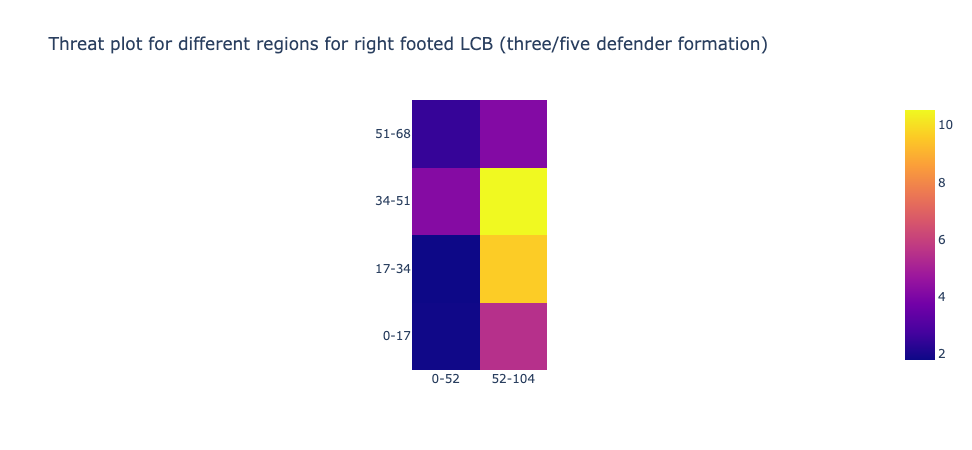

In [41]:
# The graphs have been saved in 'threat_plots' data folder
pcolorplotter(
    three_five_rf_lcbs_regionwiseoff,
    'Threat plot for different regions for right footed LCB (three/five defender formation)',
    'offvalue_right_lcb_3_5_def')

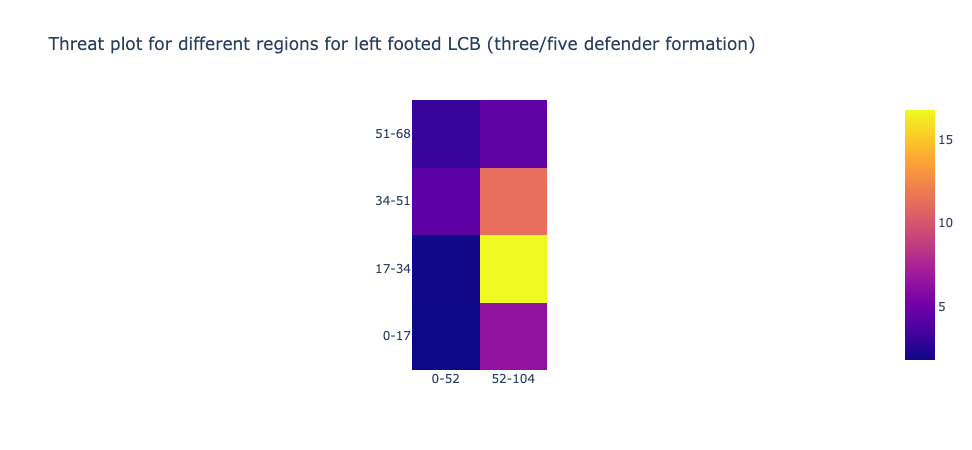

In [42]:
# The graphs have been saved in 'threat_plots' data folder
pcolorplotter(
    three_five_lf_lcbs_regionwiseoff,
    'Threat plot for different regions for left footed LCB (three/five defender formation)',
    'offvalue_left_lcb_3_5_def')

**Results:** 

1. Left footed LCBs deliver more threat on right flank attack region than right footed LCBs, even though right footed LCBs prefer this region over left footed LCBs to make accurate progressive passes.

2. Left footed LCBs deliver more threat on left flank attack region than right footed LCBs and also prefer to make more accurate progressive passes than the counterpart.
    